In [1]:
# only needed once
#!pip install camb # only installs for default kernel?
#!pip install emcee

In [1]:
import os
import emcee
import corner
import numpy as np
from scipy import special
import matplotlib.pyplot as plt

plt.rc('axes', labelsize=15) # fontsize of the x- and y-axis labels
plt.rc('axes', titlesize=17) # fontsize of the axes title
x_label_multipole = r'multipole $\ell$' # I use l in Overleaf though

folder = "bulk_data/code_output/"
mcmc_folder            = folder+"mcmc_runs/"
cmb_spectra_folder     = folder+"cmb_power_spectra/"
lensing_spectra_folder = folder+"lensing_power_spectra/"
figures_folder = "figures/"

In [2]:
parameter_list = ['tau', 'H0', 'ombh2', 'omch2', 'ns', 'As']

parameters_dict = {
            'tau': 0.0543,
            'H0': 67.32,
            'ombh2': 0.022383,
            'omch2': 0.12011,
            'log(As)': np.log(2.1e-9),
            'ln(As)': np.log(2.1e-9),
            'As': 2.1e-9,
            'ns': 0.96605
            }

parameters_latex = {
                  "H0":r"H_0",
                  "ombh2":r"\Omega_{b,0} h^2",
                  "omch2":r"\Omega_{c,0} h^2",
                  "tau":r"\tau",
                  "As":r"A_s",
                  "ln(As)":r"\ln(A_s)",
                  "log(As)":r"\log(A_s)",
                  "ns":r"n_s",
                  "nnu":r"n_\nu", # or r"N_\mathrm{eff}" ?
                  "omk":r"\Omega_k",
                  "mnu":r"M_\nu",
                  "r":r"r",
                  "HMCode_A_baryon":r"A",
                  "HMCode_eta_baryon":r"\eta_0"}

autocorrelation time = [32.69050718 48.92176352 49.00761972 45.18172335 52.86641153 63.15477537]
Sampler is estimated to terminate at 3157.7 iterations.
Estimated time left: -80.75 min
flat_samples.shape = (6656, 6)


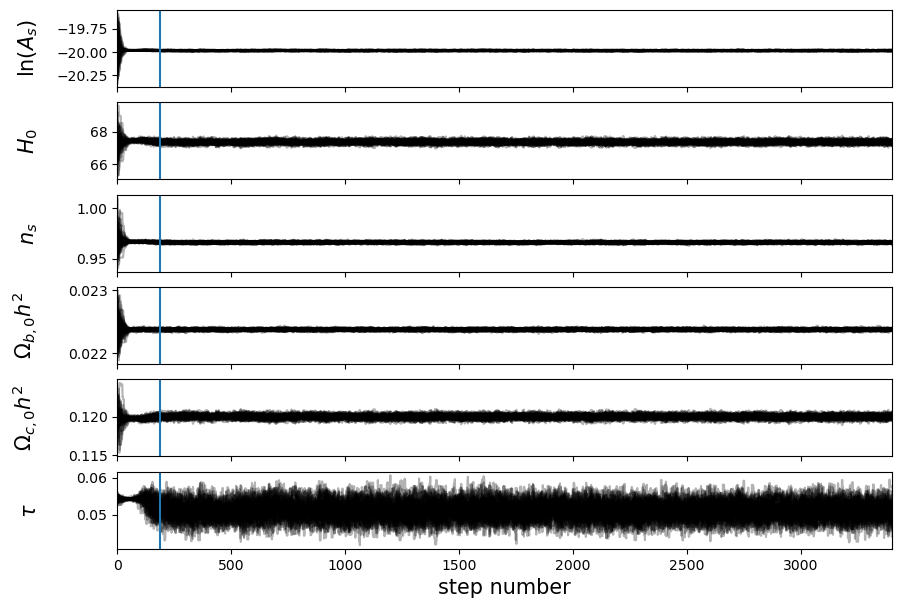

In [8]:
model = "BAHAMAS-LowAGN"
#model = None
#filename = f"mcmc_sample_H0_ombh2_omch2_tau_log(As)_ns_5000_delta_tot_{model}.h5"
# filename = f"mcmc_sample_tau_H0_ombh2_omch2_ln(As)_ns_5000_delta_tot_{model}_new.h5"
# filename = f"mcmc_sample_tau_H0_ombh2_omch2_ns_ln(As)_5000_delta_tot_{model}_new.h5"
#filename = f"mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_delta_tot_{model}_new.h5"
#filename = "mcmc_sample_H0_ombh2_omch2_tau_log(As)_ns_5000_delta_tot_BAHAMAS-HighAGN.h5"
filename = f"mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_delta_tot_{model}_vs_BAHAMAS-HighAGN.h5"
#filename = f"mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_delta_tot_{model}_vs_OWLS-AGN.h5"
filename = f"mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_{model}_vs_BAHAMAS-HighAGN_acc1.h5"

sampler = emcee.backends.HDFBackend(mcmc_folder+filename)
samples = sampler.get_chain()


#samples = samples[1756-16:1756] # location of spike
#samples = np.vstack([samples[:1756-16], samples[1756:]])


#parameter_labels = ['H0', 'tau']
parameter_labels = filename.split('_')[2:-1]
parameters_vector = np.array([parameters_dict[key] for key in parameter_labels[:6]])
parameter_labels = [f"${parameters_latex[label]}$" for label in parameter_labels[:6]]

plot_lin_As = False

if "$"+parameters_latex['log(As)']+"$" in parameter_labels:
    idx = parameter_labels.index("$"+parameters_latex['log(As)']+"$")
else:
    idx = parameter_labels.index("$"+parameters_latex['ln(As)']+"$")

if plot_lin_As:
    samples[:,:,idx] = np.exp(samples[:,:,idx])
    parameter_labels[idx] = '$A_s$'
    parameters_vector[idx] = np.exp(parameters_vector[idx])


fig, frames = plt.subplots(samples.shape[-1], figsize=(10, 7), sharex=True)
for i, frame in enumerate(frames):
    frame.plot(samples[:, :, i], "k", alpha=0.3)
    frame.set_xlim(0, len(samples))
    frame.set_ylabel(parameter_labels[i])
    frame.yaxis.set_label_coords(-0.1, 0.5)

frames[-1].set_xlabel("step number")

tau = sampler.get_autocorr_time(tol=0) # steps for the walker's positions to be uncorrelated with their initial positions
print(f'autocorrelation time = {tau}')
print(f'Sampler is estimated to terminate at {50*tau.max():.1f} iterations.')
print(f'Estimated time left: {20*(50*tau.max() - len(samples))/60:.2f} min')

discard = int(3*tau.max())
[frame.axvline(discard) for frame in frames]

thin = max(int(tau.max()/2), 1)
flatten = True

#flat_samples_orig = sampler.get_chain(discard=discard, thin=thin, flat=flatten)

# rewrite get_chain to use the modified samples:
flat_samples = samples[discard::thin]
if flatten:
    flat_samples = flat_samples.reshape((flat_samples.shape[0]*flat_samples.shape[1], flat_samples.shape[2]))
print(f'{flat_samples.shape = }')

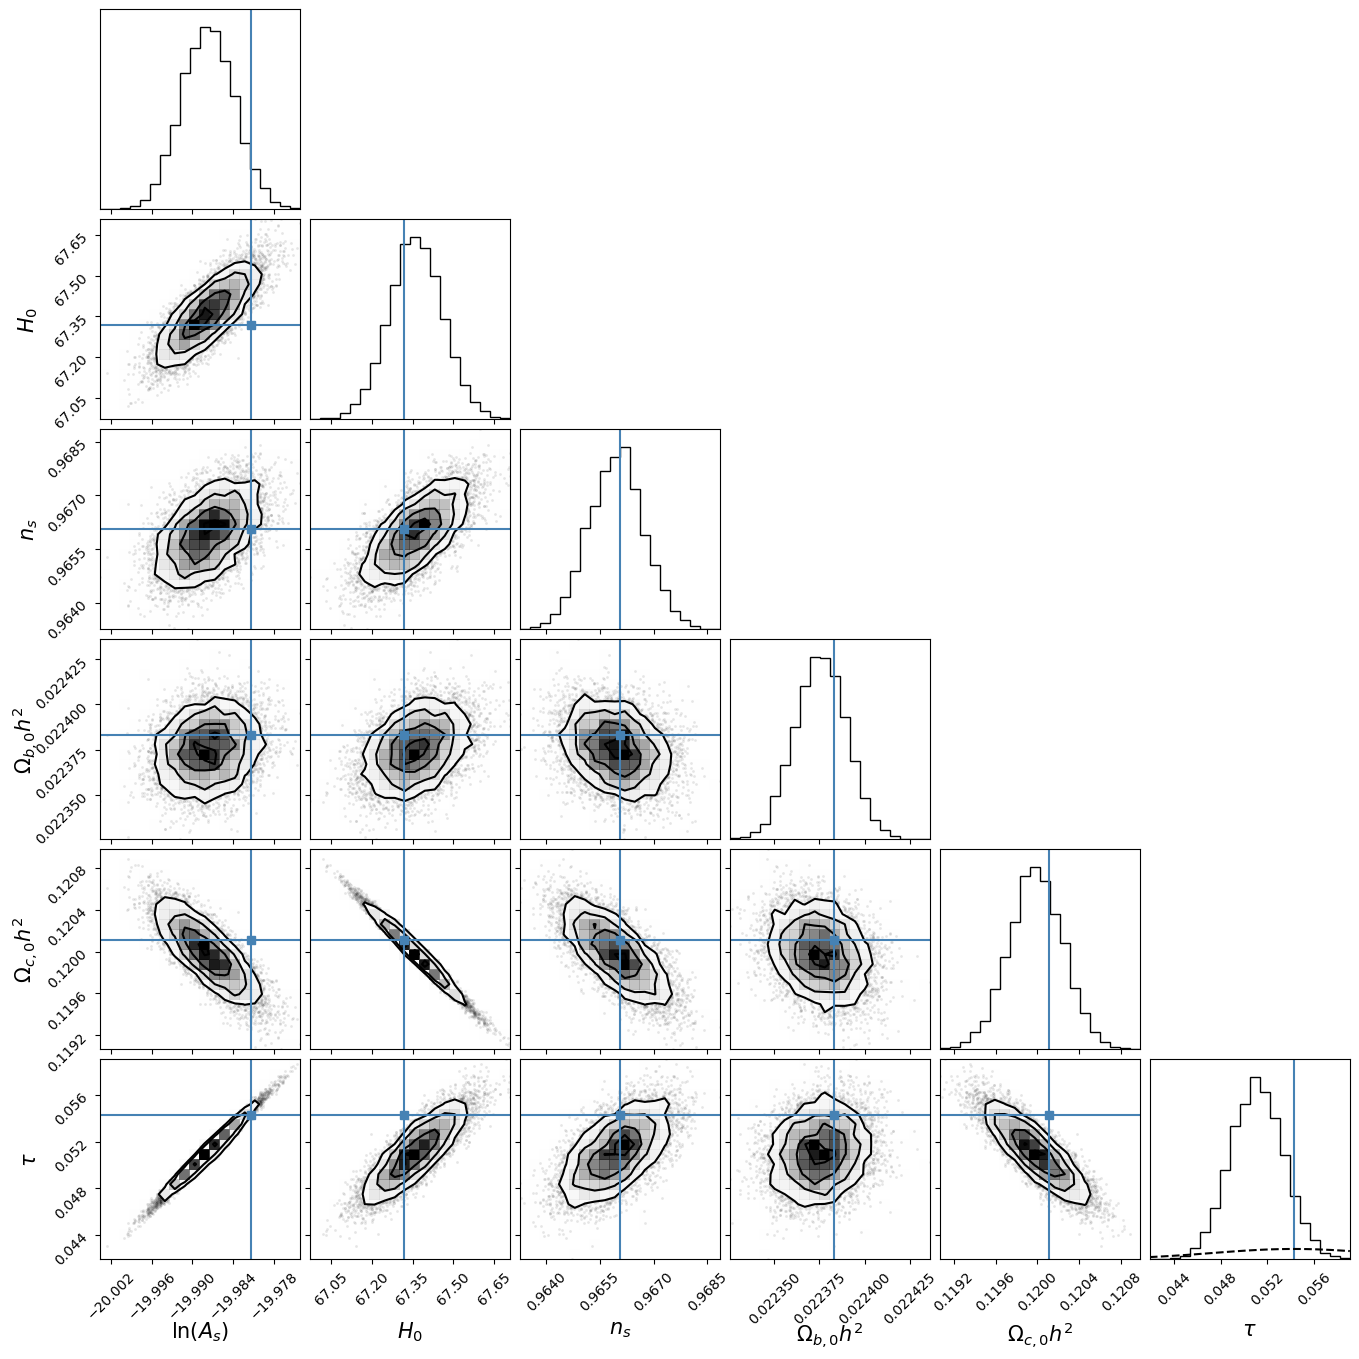

In [9]:
fig = corner.corner(flat_samples, labels=parameter_labels, truths=parameters_vector) # default contour lines are for 0.5-2 sigma in steps of 0.5 sigma

# add prior to posterior plot of tau:
sigma = 0.007
frame = fig.axes[-1] # not generic
x = np.linspace(*frame.get_xlim(), 100)
frame.plot(x, (2*np.pi*sigma**2)**-0.5 * np.exp(-(x - parameters_dict["tau"])**2 /2/sigma**2), c='k', ls='--')

In [5]:
from IPython.display import display, Math

parameters_best_guess = np.empty(samples.shape[-1])

for i in range(samples.shape[-1]):
    mcmc = np.percentile(flat_samples[:, i], 50*(1 + special.erf(1/2**0.5)*np.arange(-1, 2))) # 1-sigma interval for 1d Gaussian
    q = np.diff(mcmc)
    display(Math(parameter_labels[i]+f" $ = {mcmc[1]:.3f}_{{-{q[0]:.2}}}^{{+{q[1]:.2}}}$")) # todo: improve rounding
    parameters_best_guess[i] = mcmc[1]

sigmas = np.std(flat_samples, 0)
normalized_bias = abs(parameters_best_guess - parameters_vector)/sigmas
print(f'{normalized_bias = }')

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

normalized_bias = array([1.6328163 , 0.43216852, 0.10969399, 0.5133008 , 0.49338075,
       1.41421146])


Loading data from bulk_data/code_output/mcmc_runs/mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_BAHAMAS-HighAGN_vs_BAHAMAS-HighAGN_acc1.h5
normalized_bias = array([0.05726869, 0.02103184, 0.00992711, 0.0021601 , 0.00727051,
       0.04400212])
Loading data from bulk_data/code_output/mcmc_runs/mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_BAHAMAS-LowAGN_vs_BAHAMAS-HighAGN_acc1.h5
normalized_bias = array([1.62018624, 0.42092189, 0.10030131, 0.51195895, 0.49484932,
       1.3998973 ])
Loading data from bulk_data/code_output/mcmc_runs/mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_None_vs_BAHAMAS-HighAGN_acc1.h5
normalized_bias = array([2.56317942, 0.76203763, 0.13671489, 0.74871224, 0.87281418,
       2.21460609])


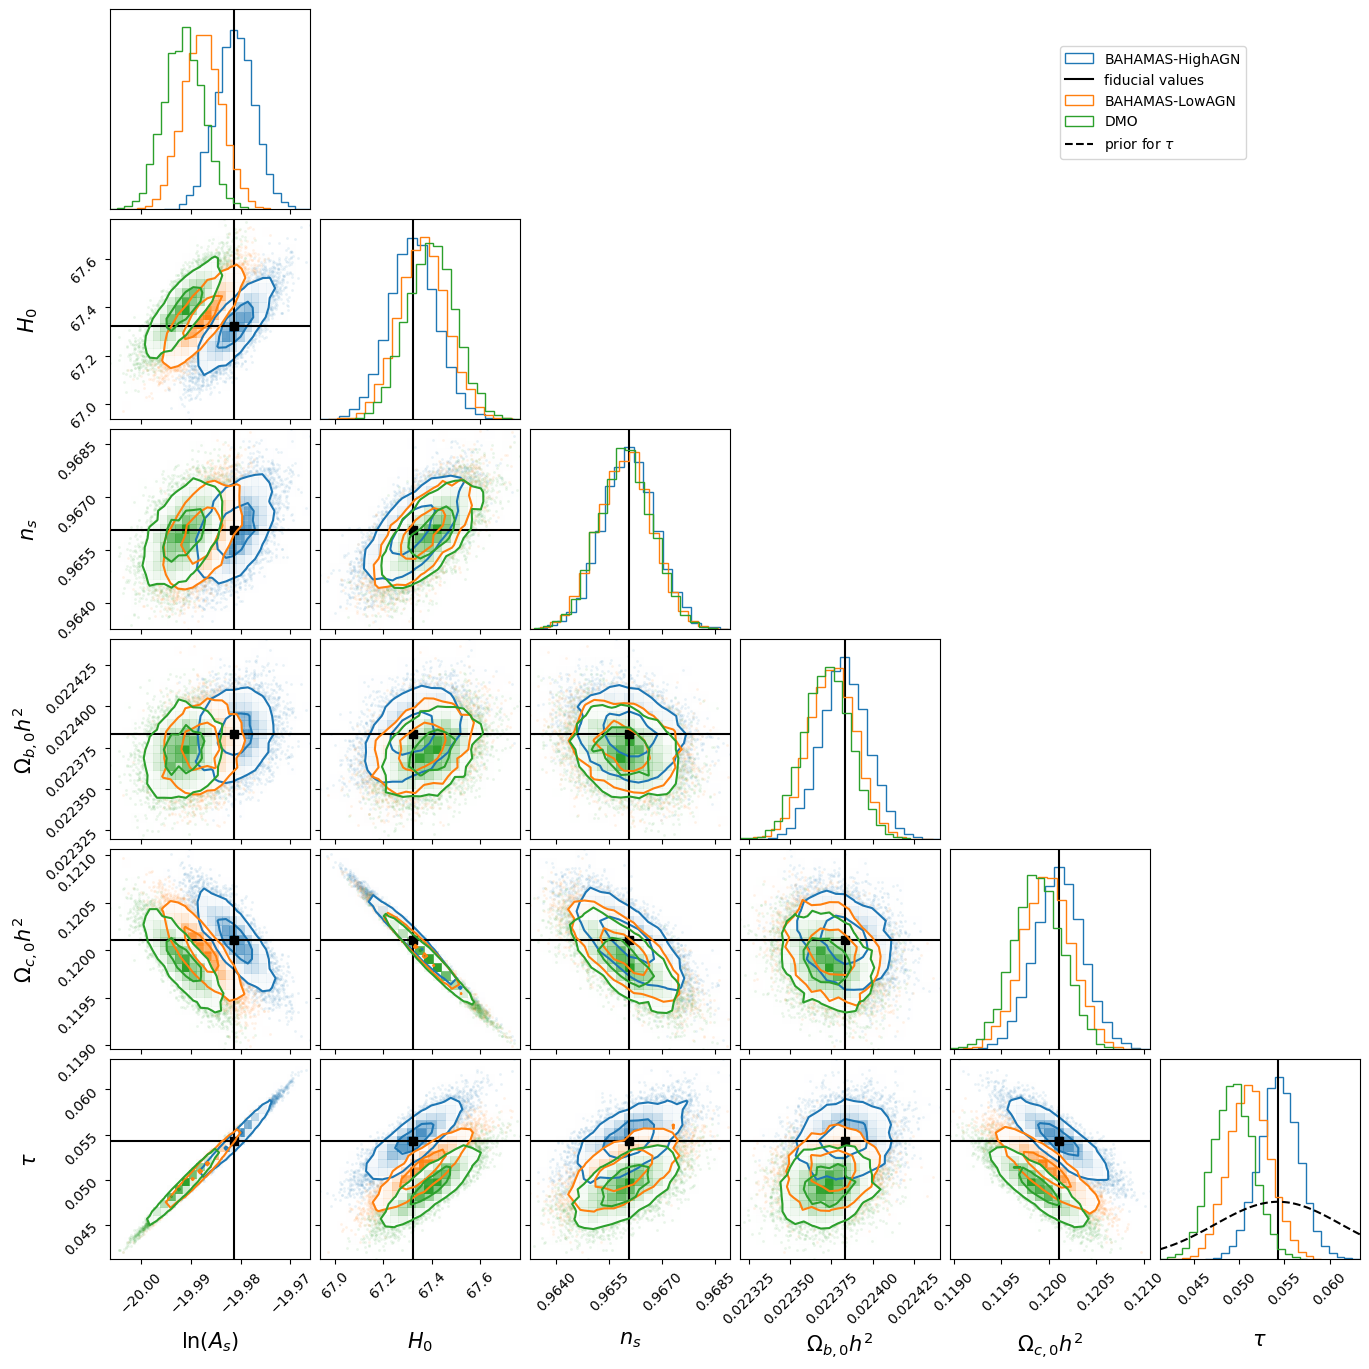

In [6]:
# make plot for paper

def get_flat_samples(filename, tol=50):
    """
    Input:
    filename:str
    
    Return:
    flat_samples:np.array
    """
    print(f"Loading data from {filename}")
    sampler = emcee.backends.HDFBackend(filename)
    tau = sampler.get_autocorr_time(tol=tol, quiet=True) # print warning instead of raising an error
    
    flat_samples = sampler.get_chain(discard=int(3*tau.max()), thin=max(int(tau.max()/2), 1), flat=True)
    if plot_lin_As:
        flat_samples[:,idx] = np.exp(flat_samples[:,idx])

    normalized_bias = abs(np.median(flat_samples, 0) - parameters_vector)/np.std(flat_samples, 0)
    print(f'{normalized_bias = }')
    
    return flat_samples

generic_file_name = "mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_delta_tot_{}_vs_BAHAMAS-HighAGN.h5" # f-string
generic_file_name = "mcmc_sample_ln(As)_H0_ns_ombh2_omch2_tau_5000_{}_vs_BAHAMAS-HighAGN_acc1.h5" # f-string

labels = ['BAHAMAS-HighAGN', 'BAHAMAS-LowAGN', 'None']
sigmas = np.array([1, 2])
levels = 1 - np.exp(-(sigmas)**2/2) # note that this is different to the formula for 1d-sigmas
plot_lin_As = False # set to True to compare the normalized bias to McCarthy

if plot_lin_As:
    parameter_labels[idx] = '$A_s$' # idx is taken from previous cells, same as paramter_labels
    parameters_vector[idx] =  parameters_dict["As"]
else:
    parameter_labels[idx] = r'$\ln(A_s)$' 
    parameters_vector[idx] =  parameters_dict["ln(As)"]

# default contour lines are for 0.5-2 sigma in steps of 0.5 sigma
fig = corner.corner(get_flat_samples(mcmc_folder + generic_file_name.format(labels[0])), levels=levels, labels=parameter_labels, labelpad=0.05, truths=parameters_vector, truth_color='k', color=f'C0', hist_kwargs={'density':True})
[corner.corner(get_flat_samples(mcmc_folder + generic_file_name.format(model)), levels=levels, labels=parameter_labels, labelpad=0.05, fig=fig, truth_color='k', color=f'C{i+1}', hist_kwargs={'density':True}) for i, model in enumerate(labels[1:])] # omit truths here, otherwise it appears in the legend multiple times 

# add prior to posterior plot of tau:
sigma = 0.007
frame = fig.axes[-1] # not generic
x = np.linspace(*frame.get_xlim(), 100)
frame.plot(x, (2*np.pi*sigma**2)**-0.5 * np.exp(-(x - parameters_dict["tau"])**2 /2/sigma**2), c='k', ls='--')

frame.legend([labels[0], 'fiducial values', labels[1], 'DMO', r'prior for $\tau$'], loc=(-0.5, 5.5)) # not generic
fig.savefig(figures_folder+'overlayed_corner_plots')

See   
https://corner.readthedocs.io/en/latest/pages/sigmas/ - to check the sigma-percentile relations  
https://en.wikipedia.org/wiki/68%E2%80%9395%E2%80%9399.7_rule to find a general formula to convert between sigmas and percentiles

Use $\ln(\tau)$ instead of $\tau$? as it can't be negative.  
As long as CAMB doesn't error I think it's fine, as using $\ln(A_s)$ instead of $A_s$ was mainly so that a uniform prior could be used, while I wouldn't want to change the prior on $\tau$ if using $\ln(\tau)$.
Note: the sampler has tried some negative $\tau$ values.

Todo: try running the sampler again with a more accurate model

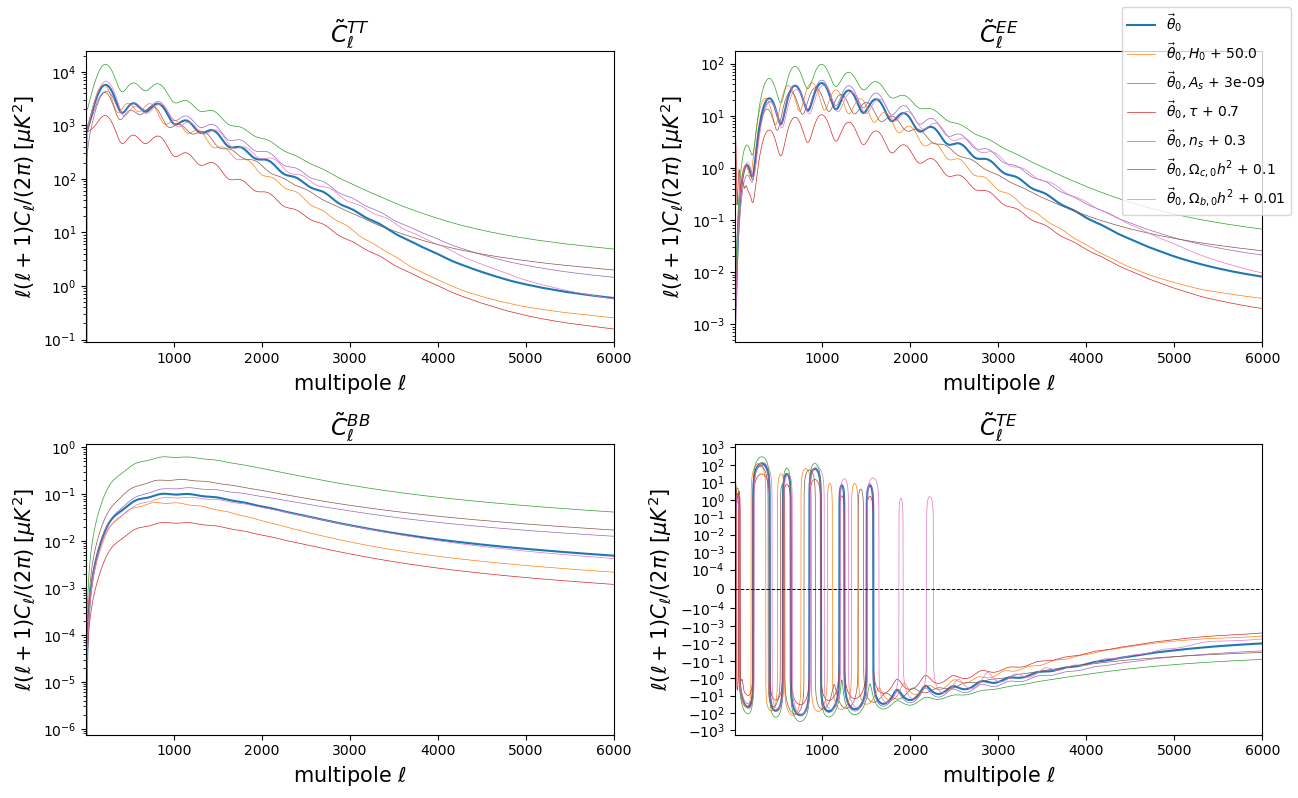

In [10]:
## draw plot for introduction, version 1

# loading data:
CMB_power_spectra = np.load(cmb_spectra_folder+'cmb_power_spectra.npy', allow_pickle=True)[()] # dictionary of (l(l+1)C_l/(2\pi), l) data, need to index with empty tuple to unpack from the 0-dim array it is put in for saving
CMB_power_spectra_unit = "\mu K^2"
CMB_power_spectra_labels = ["TT", "EE", "BB", "TE"]

CMB_power_spectra_neighborhood = {}
change_in_parameters = {}
for filename in os.listdir(cmb_spectra_folder): # also includes directory names
    splitname = filename.split('_')
    if '_'.join(splitname[:3]) == "cmb_power_spectra":
        key = splitname[-1].split('.')[0]
        if splitname[-2] == "*":
            continue # skip names with "*" in position -2
        if key in CMB_power_spectra_neighborhood.keys():
            print(f'duplicate key: {key}')
        CMB_power_spectra_neighborhood[key] = np.load(cmb_spectra_folder+filename, allow_pickle=True)[()]
        change_in_parameters[key]  = float(splitname[-2])

# settings:
l_max = 6000 # set to -1 to remove limit for the graphs

fig, frames = plt.subplots(2, 2, figsize=(13, 8))
i = 0
for frame_row in frames:
    for frame in frame_row:
        frame.plot(CMB_power_spectra["lensed_scalar"][:l_max,i], label="lensed")
        #frame.plot(CMB_power_spectra["unlensed_scalar"][:l_max,i], label="unlensed", lw=1)

        for parameter, CMB_power_spectra_new in CMB_power_spectra_neighborhood.items():
            frame.plot(CMB_power_spectra_new["lensed_scalar"][:l_max,i], label=f"lensed +$\Delta${parameter}", lw=0.5)
            #frame.plot(CMB_power_spectra_new["unlensed_scalar"][:l_max,i], label=f"unlensed +$\Delta${parameter}", lw=0.5)
        
        frame.set_ylabel(fr"$\ell(\ell+1)C_\ell/(2\pi)\; [{CMB_power_spectra_unit}]$", fontsize=15)
        frame.set_xlabel(x_label_multipole)
        frame.set_title(r"$\tilde{C}_\ell^{" + CMB_power_spectra_labels[i] + "}$", fontsize=17)
        if l_max != -1:
            frame.set_xlim(2, l_max)
            pass
        else:
            frame.margins(0)
        frame.set_yscale('log')
        #frame.set_xscale('log')
        i += 1
frame.set_yscale("symlog", linthresh=1e-4)
#frame.set_yscale("linear")
#frame.set_ylim(-150, 150)
#frame.legend(loc=(0.68, 0.5))
frame.axhline(0, c='k', ls='--', lw=0.7)
fig.legend([r"$\vec{\theta}_0$", *[fr"$\vec{{\theta}}_0, {parameters_latex[parameter]}$ + {change_in_parameters[parameter]}" for parameter in CMB_power_spectra_neighborhood.keys()]])
fig.tight_layout()
fig.savefig(figures_folder+f'fig_introduction')

Saved to figures/fig_introduction_[22. 24.]_custom_v2_new_labels.png


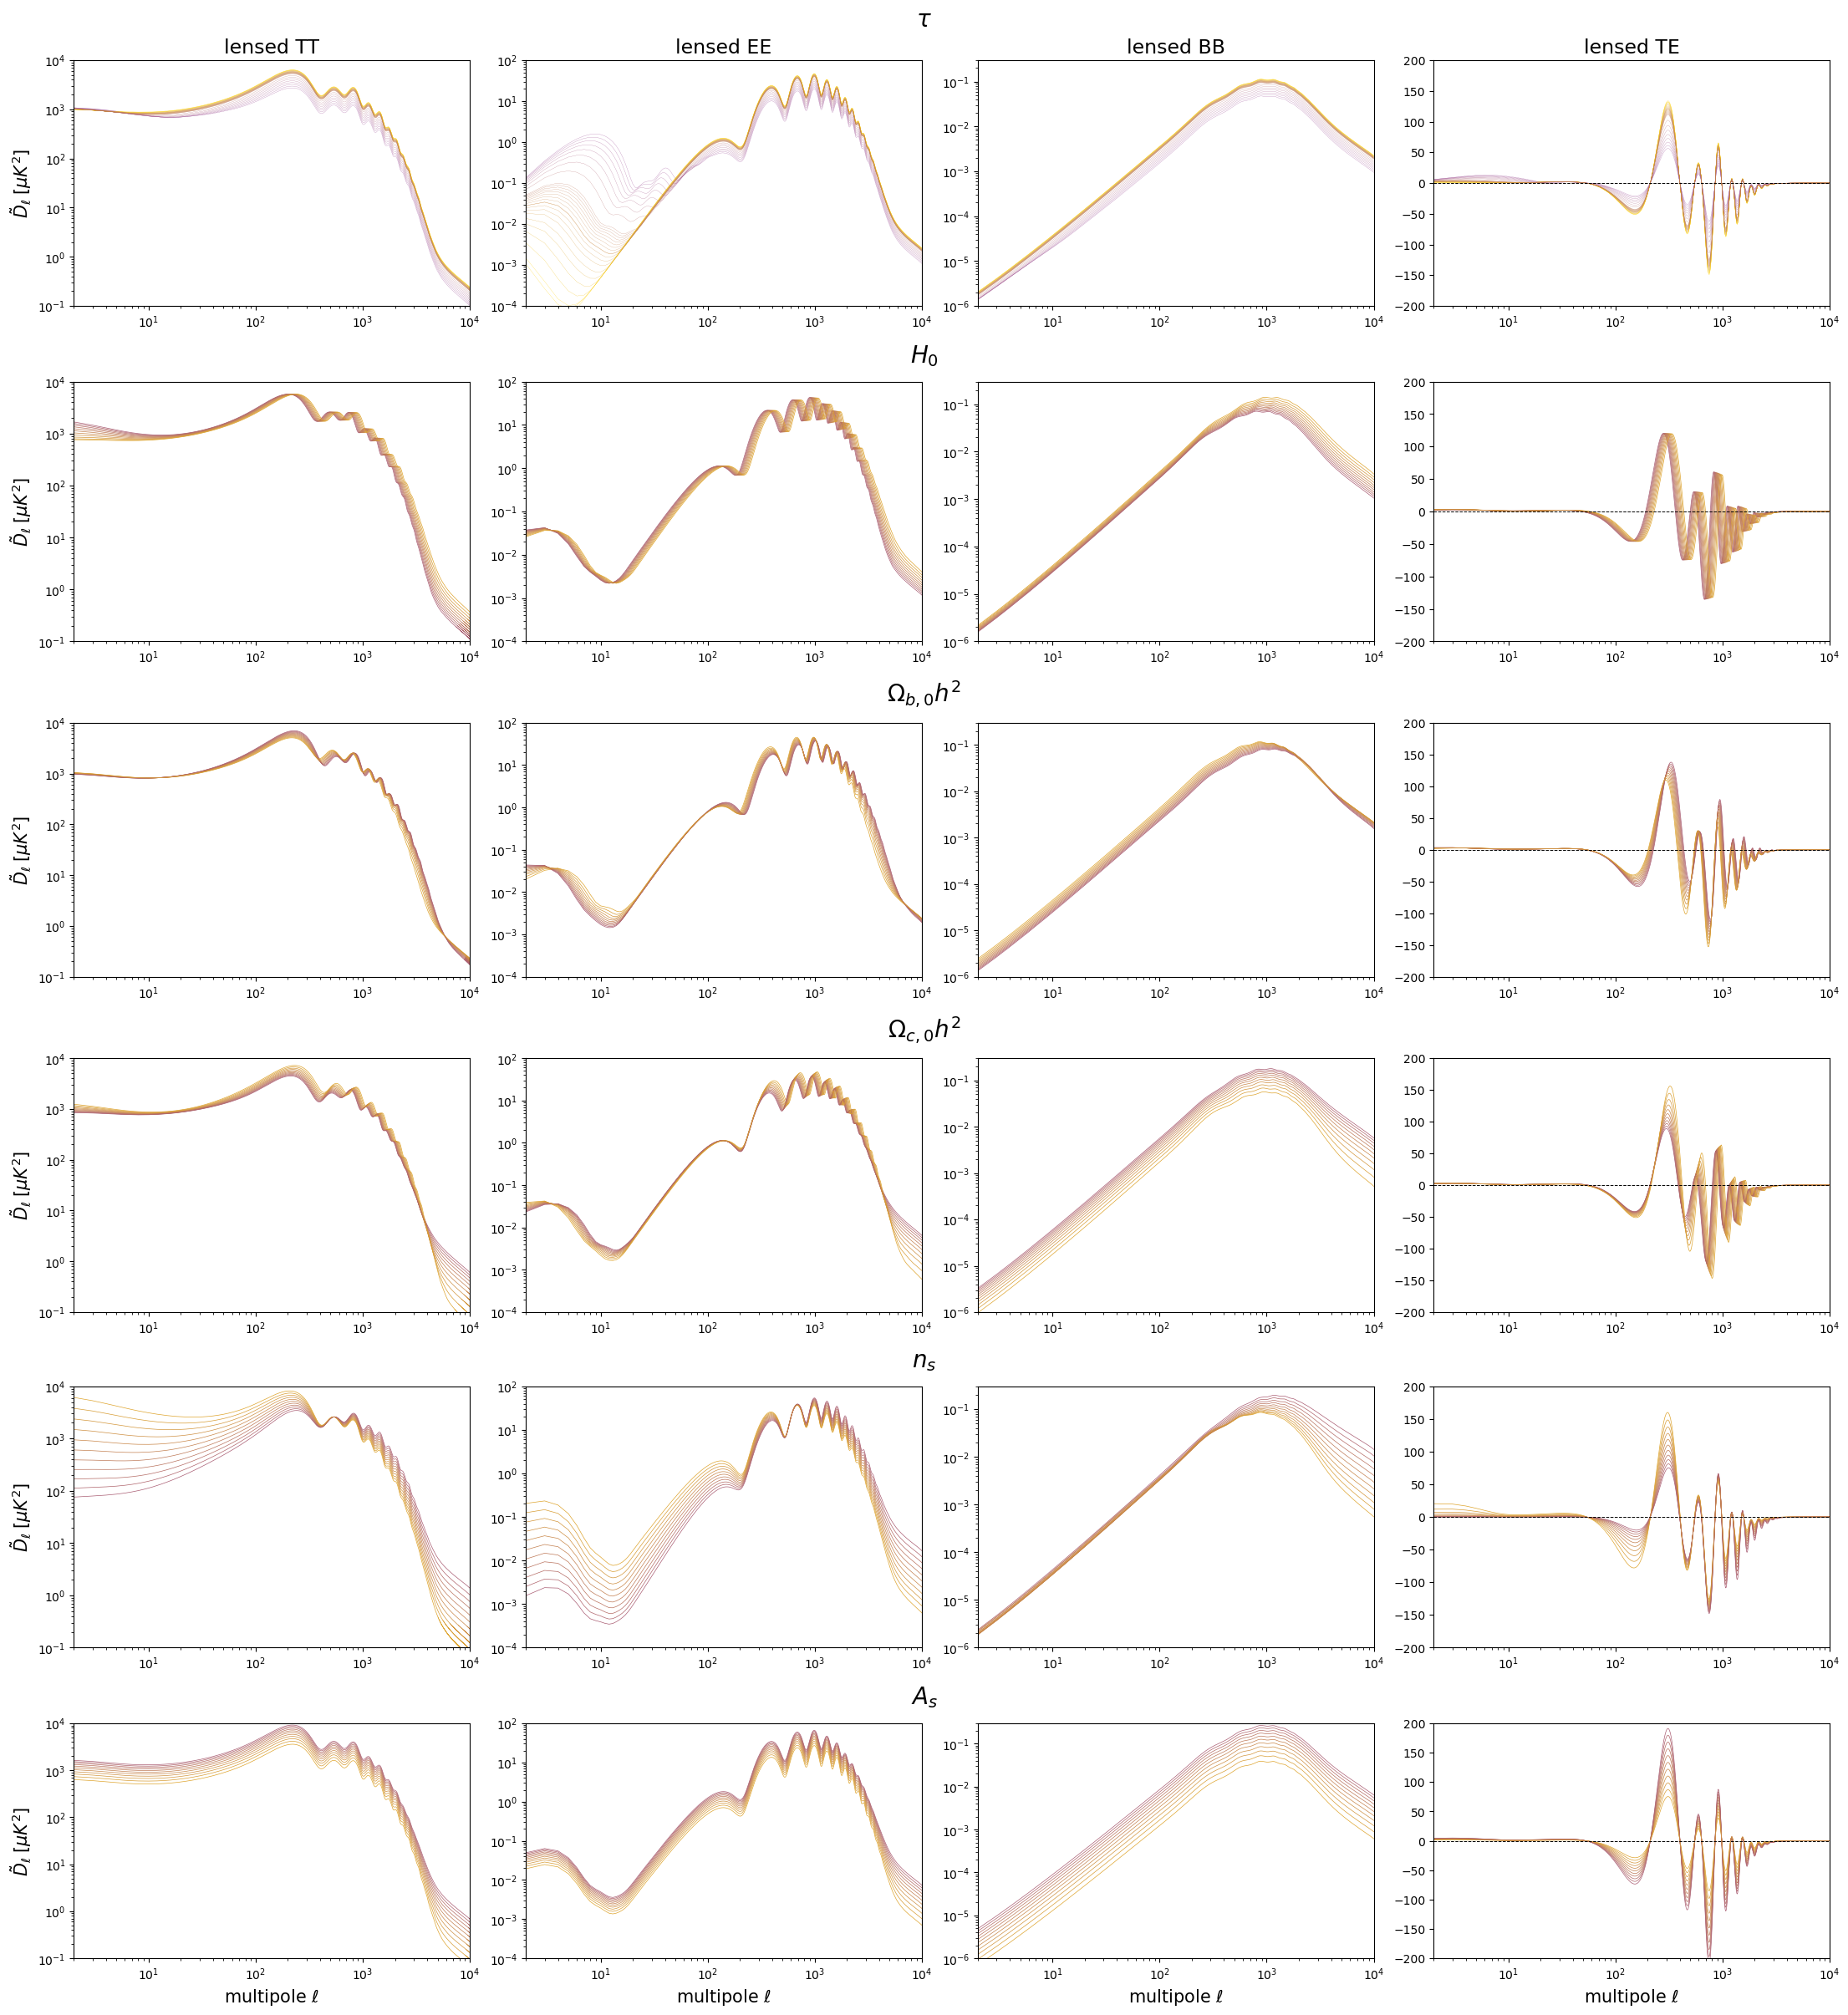

In [7]:
## draw plot for introduction, version 2

def custom_colormap(ratio):
    """
    Maps numbers in [0, 1] to colors between start_color and end_color, linearly in RGBA space.
    
    Input:
    ratio:+float: number in [0, 1]
    
    Return:
    color:np.array of +float: all values must be in [0, 1]
    """
    ratio = max(0, ratio)
    start_color = np.array([255, 211,  0, 255])/255 # cyber yellow
    end_color   = np.array([148, 62, 143, 255])/255 # purple
    return end_color*ratio + start_color*(1 - ratio)

# loading data:
CMB_power_spectra = np.load(cmb_spectra_folder+'cmb_power_spectra.npy', allow_pickle=True)[()] # dictionary of (l(l+1)C_l/(2\pi), l) data, need to index with empty tuple to unpack from the 0-dim array it is put in for saving
CMB_power_spectra_unit = "\mu K^2"
CMB_power_spectra_labels = ["TT", "EE", "BB", "TE"]

CMB_power_spectra_neighborhood = {key:{} for key in parameter_list} # dictionary of dictionaries
for filename in os.listdir(cmb_spectra_folder): # also includes directory names
    splitname = filename.split('_')
    if '_'.join(splitname[:3]) == "cmb_power_spectra":
        key = splitname[-1].split('.')[0]
        if splitname[-2] == "*":
            factor = float(splitname[-3])
            if factor in CMB_power_spectra_neighborhood[key].keys():
                print(f'duplicate key: {key}.{factor}')
#             if not 1/1.6 <= factor <= 1.6:
#                 continue
            CMB_power_spectra_neighborhood[key][factor] = np.load(cmb_spectra_folder+filename, allow_pickle=True)[()]

# settings:
l_max = 10000 # set to -1 to remove limit for the graphs
max_factor = 1.6

cmap_name = 'custom'
if cmap_name == 'custom':
    colormap = custom_colormap
else:
    colormap = plt.colormaps[cmap_name]
subfig_layout_mode = 2 # 1 for 2x2, 2 for 1x4

fig = plt.figure(layout='constrained')
subfigs = fig.subfigures(6, 1, squeeze=False) # different subfigure for each parameter
fig.set_size_inches(11*subfigs.shape[1]*subfig_layout_mode, 8*subfigs.shape[0]/subfig_layout_mode)

for i, (parameter, CMB_power_spectra_neighborhood_slice) in enumerate(CMB_power_spectra_neighborhood.items()):
    subfig = subfigs.ravel()[i]
    frames = subfig.subplots(2//subfig_layout_mode, 2*subfig_layout_mode, squeeze=False)
    subfig.suptitle(fr'${parameters_latex[parameter]}$', fontsize=20)
    frame_num = 0
    for frame_row in frames:
        for frame in frame_row:
            for factor, CMB_power_spectra_new in CMB_power_spectra_neighborhood_slice.items():
                if parameter == 'tau':
                    color = colormap((np.emath.logn(8, factor) +1)/2) # [1/8, 8] -> [0, 1] (logarithmic)
                    lw = 0.15 # otherwise it seems to have higher saturation
                else:
                    color = colormap(factor/2) # [0, 2] -> [0, 1] (linear)
                    lw = 0.5
                frame.plot(CMB_power_spectra_new["lensed_scalar"][:l_max,frame_num], lw=lw, color=color)
                #frame.plot(CMB_power_spectra_new["unlensed_scalar"][:l_max,frame_num], lw=lw)
        
            #frame.set_ylabel(fr"$\ell(\ell+1)C_\ell/(2\pi)\; [{CMB_power_spectra_unit}]$", fontsize=15)
            if i == 0:
                frame.set_title(f"lensed {CMB_power_spectra_labels[frame_num]}", fontsize=17)
            f_mod_4 = frame_num % 4
            if f_mod_4 == 0:
                frame.set_ylim(1e-1, 1e4)
                frame.set_ylabel(fr"$\tilde D_\ell \; [{CMB_power_spectra_unit}]$", fontsize=15)
            elif f_mod_4 == 1:
                frame.set_ylim(1e-4, 1e2)
            elif f_mod_4 == 2:
                frame.set_ylim(1e-6, 3e-1)
            if l_max != -1:
                frame.set_xlim(2, l_max)
                pass
            else:
                frame.margins(0)
            frame.set_yscale('log')
            frame.set_xscale('log') # much better to see effect of tau at small l
            frame_num += 1
    # for every 4th frame:
    #frame.set_yscale("symlog", linthresh=1e-4)
    frame.set_yscale("linear")
    frame.set_ylim(-200, 200)
    frame.axhline(0, c='k', ls='--', lw=0.7)
for frame in frame_row: # loop over last row again
     frame.set_xlabel(x_label_multipole)
filename = figures_folder+f'fig_introduction_{fig.get_size_inches()}_{cmap_name}_v{subfig_layout_mode}_new_labels.png' # need to add .png, otherwise .0 is misinterpreted
fig.savefig(filename)
print(f'Saved to {filename}')

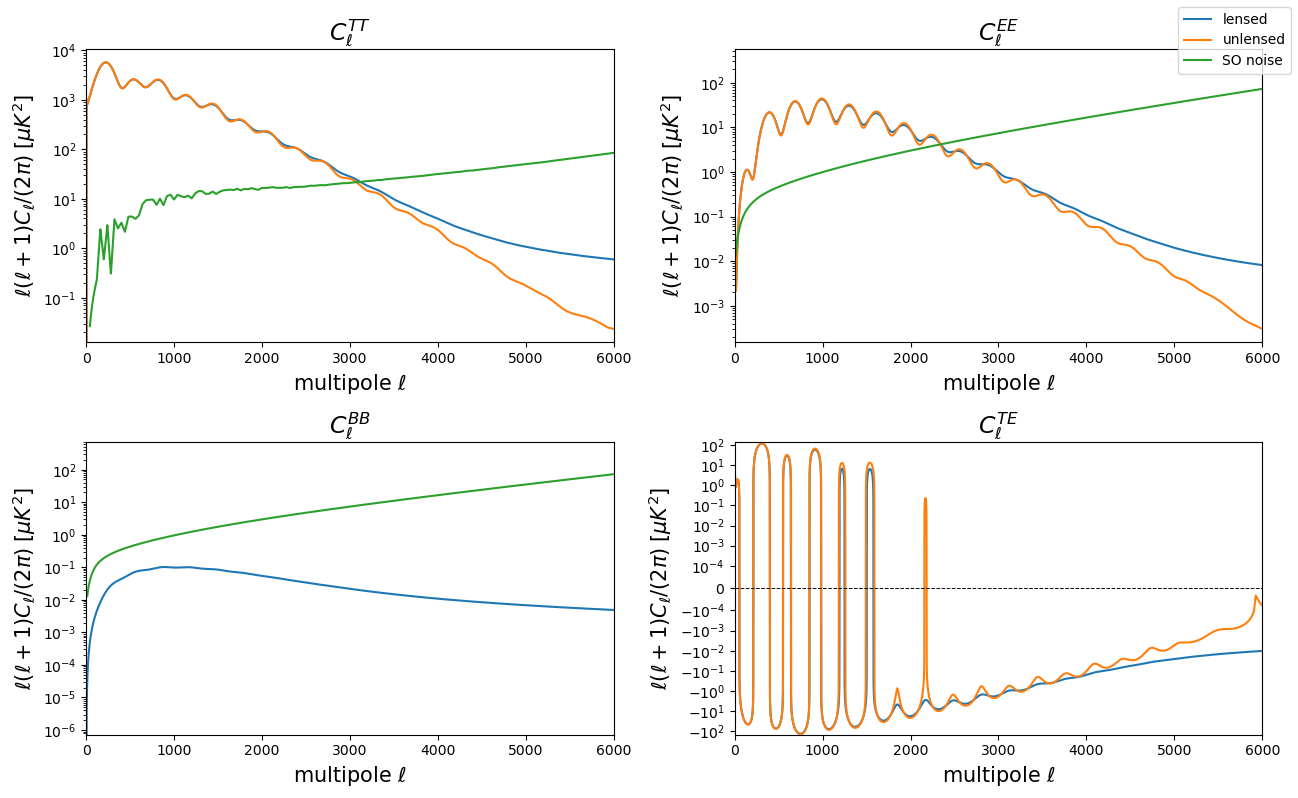

In [10]:
## figure 1 from first paper
# loading saved data from files
CMB_power_spectra = np.load(cmb_spectra_folder+'cmb_power_spectra.npy', allow_pickle=True)[()] # dictionary of (l(l+1)C_l/(2\pi), l) data, need to index with empty tuple to unpack from the 0-dim array it is put in for saving
CMB_power_spectra_labels = ["TT", "EE", "BB", "TE"]
CMB_power_spectra_lens_potential_labels = ["PP", "PT", "PE"]
CMB_power_spectra_unit = "\mu K^2"

# loading data from files downloaded from GitHub
folder = "./bulk_data/so_noise_models/LAT_comp_sep_noise/v3.1.0/"
file_names = {"N_lens_TT": "SO_LAT_Nell_T_atmv1_goal_fsky0p4_ILC_CMB.txt", # have to keep the order the same as CMB_power_spectra_labels
              "N_lens_EE": "SO_LAT_Nell_P_goal_fsky0p4_ILC_CMB_E.txt",
              "N_lens_BB": "SO_LAT_Nell_P_goal_fsky0p4_ILC_CMB_B.txt",
             }

noise_spectra = {"SO":{key:np.loadtxt(folder + file_name) for key, file_name in file_names.items()}} # C_l in muK^2
noise_spectrum_labels = ["multipole", "deproj-0", "deproj-1", "deproj-2", "deproj-3"]
# SO data has some Planck noise

l_max = 6000 # set to -1 to remove limit for the graphs

fig, frames = plt.subplots(2, 2, figsize=(13, 8))
i = 0
for frame_row in frames:
    for frame in frame_row:
        frame.plot(CMB_power_spectra["total"][:l_max,i],)# label="lensed")
        frame.plot(CMB_power_spectra["unlensed_total"][:l_max,i],)# label="unlensed")
        for survey, noise_data in noise_spectra.items():
            try: # check noise_spectra
                key = "N_lens_" + CMB_power_spectra_labels[i]
                l = noise_data[key][:,0]
                frame.plot(l, l*(l+1)/(2*np.pi) * noise_data[key][:,1]) #label=f"{survey} noise")
            except KeyError:
                pass
        frame.set_ylabel(fr"$\ell(\ell+1)C_\ell/(2\pi)\; [{CMB_power_spectra_unit}]$")
        frame.set_xlabel(x_label_multipole)
        frame.set_title(r"$C_\ell^{" + CMB_power_spectra_labels[i] + "}$")
        if l_max != -1:
            frame.set_xlim(0, l_max)
        else:
            frame.margins(0)
        frame.set_yscale("log")
        #frame.legend()
        i += 1
frame.set_yscale("symlog", linthresh=1e-4)
#frame.set_yscale("linear")
frame.set_ylim(-150, 150)
frame.axhline(0, c='k', ls='--', lw=0.7)
fig.legend(['lensed', 'unlensed', f'{survey} noise'])
fig.tight_layout()
fig.savefig(figures_folder+"fig_1")

/tmp/ipykernel_3223602/4021875119.py:34: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  frame.set_xlim(0, 12050)
/tmp/ipykernel_3223602/4021875119.py:36: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.savefig(figures_folder+f'clkk_integral_comparison') # legend can move slightly in the saved image


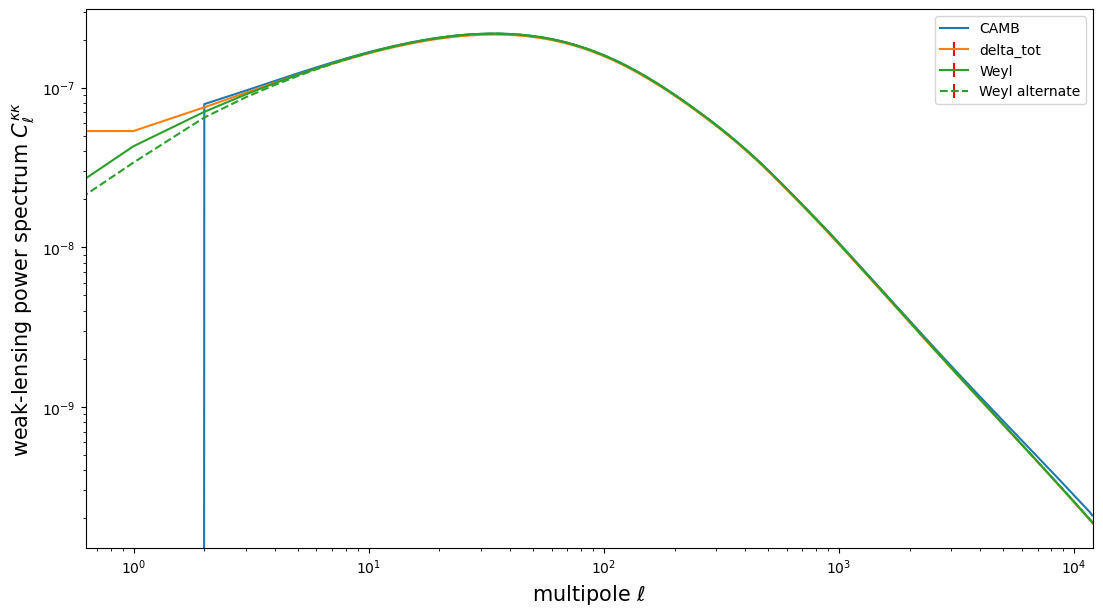

In [11]:
# comparing integrals:

## loading saved data from files
CMB_power_spectra = np.load(cmb_spectra_folder+'cmb_power_spectra.npy', allow_pickle=True)[()] # dictionary of (l(l+1)C_l/(2\pi), l) data, need to index with empty tuple to unpack from the 0-dim array it is put in for saving
CMB_power_spectra_labels = ["TT", "EE", "BB", "TE"]
CMB_power_spectra_lens_potential_labels = ["PP", "PT", "PE"]
CMB_power_spectra_unit = "\mu K^2"

integral_labels = [
                    "delta_tot", 
                    "Weyl",
                    #"BAHAMAS-MidAGN_delta_tot",
                  ]

C_kk = {label:np.loadtxt(lensing_spectra_folder+f"c_kk_{label}.txt") for label in integral_labels}

#multipoles = np.arange(pars.max_l+1)

fig, frame = plt.subplots(figsize=(13, 7))
frame.plot(CMB_power_spectra["lens_potential"][:,0]*np.pi/2, label='CAMB') # need to convert from (l(l+1))**2 C_l_phi_phi/2/np.pi to C_l_kk
[frame.errorbar(C_kk[label][:,0], C_kk[label][:,1], yerr=C_kk[label][:,2], label=label, ecolor='r') for label in integral_labels]
#[frame.errorbar(C_kk[label][:,0], (C_kk[label][:,1]-C_kk["delta_tot"][:,1])/C_kk["delta_tot"][:,1], yerr=C_kk[label][:,2], label=label, ecolor='r') for label in integral_labels] # plot ratio

# plot alternate version of delta_tot, with less(?) approximation
l = C_kk["Weyl"][:,0] # convenience variable for next line
rescale_factor = (l*(l+1)/(l+0.5)**2)**2
frame.errorbar(l, rescale_factor*C_kk["Weyl"][:,1], yerr=rescale_factor*C_kk["Weyl"][:,2], label="Weyl alternate", ecolor='r', color='C2', ls="--")

frame.set_ylabel("weak-lensing power spectrum $C_\ell^{\kappa\kappa}$", fontsize=15)
frame.set_xlabel(x_label_multipole)
frame.set_xscale('log')
#frame.set_yscale('symlog', linthresh=1e-6)
frame.set_yscale('log')
frame.set_xlim(0, 12050)
frame.legend()
fig.savefig(figures_folder+f'clkk_integral_comparison') # legend can move slightly in the saved image